In [264]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn               import metrics
from statistics            import mean
from joblib                import load
from sklearn.impute        import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics       import roc_auc_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [265]:
%%time

meta  = pd.read_csv('data/meta.csv')
prs   = pd.read_csv('data/prs.csv')
pheno = pd.read_csv('data/pheno.csv')

<timed exec>:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 1min 16s, sys: 11.4 s, total: 1min 28s
Wall time: 1min 29s


In [266]:
prs['final_split']   = prs.split_nonWB.fillna(prs.split)
pheno['final_split'] = pheno.split_nonWB.fillna(prs.split)

In [267]:
prs = prs.drop([f"Global_PC{i+1}" for i in range(40)], axis=1)
prs = prs.drop([f"PC{i+1}" for i in range(40)], axis=1)
prs = prs.drop(['split_nonWB','IID','population','age','age0','age1','age2','age3','sex','BMI','N_CNV','LEN_CNV','Array'], axis=1)

In [268]:
disease_codes = {'diabetes': 'HC221','renal_failure': 'HC294','gout': 'HC328','myocardial_infarction': 'HC326',
                 'asthma' : 'HC382','gall_stones': 'HC188','ulcerative_colitis': 'HC201','peripheral_vascular_disease': 'HC385',
                 'atrial_flutter': 'HC440','osteoarthritis': 'HC376','arthritis_(nos)': 'HC78','TTE_cystitis': 'HC1313',
                 'TTE_chronic_renal_failure': 'HC1302','TTE_psoriasis': 'HC1159','TTE_cellulitis': 'HC1139','TTE_cholelithiasis': 'HC1125',
                 'glaucoma': 'HC276','Blood': 'BIN_FC11006152','skin_cancer': 'cancer1003'}

In [269]:
diseases      = list(disease_codes.values())
disease_names = list(disease_codes.keys())

In [308]:
disease_names

['diabetes',
 'renal_failure',
 'gout',
 'myocardial_infarction',
 'asthma',
 'gall_stones',
 'ulcerative_colitis',
 'peripheral_vascular_disease',
 'atrial_flutter',
 'osteoarthritis',
 'arthritis_(nos)',
 'TTE_cystitis',
 'TTE_chronic_renal_failure',
 'TTE_psoriasis',
 'TTE_cellulitis',
 'TTE_cholelithiasis',
 'glaucoma',
 'Blood_clot',
 'skin_cancer']

## Load models

In [270]:
def load_models(model_dir_path, disease_list):

    models = []
    
    for disease in diseases:
    
        model = load(model_dir_path + disease + '.joblib')
        models.append(model)

    return models

In [311]:
models_wb_without_prs = load_models('models/log_reg/WB_without_PRS/', diseases)
models_wb_with_prs    = load_models('models/log_reg/WB_with_PRS/', diseases)
models_wb_only_prs    = load_models('models/log_reg/WB_only_PRS/', diseases)


models_sa_without_prs = load_models('models/log_reg/SA_without_PRS/', diseases)
models_sa_with_prs    = load_models('models/log_reg/SA_with_PRS/', diseases)

In [322]:
vars(models_wb_without_prs[0])['feature_names_in_']

array(['age', 'sex', 'BMI', 'N_CNV', 'LEN_CNV', 'Array', 'PC1', 'PC2',
       'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11',
       'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27',
       'PC28', 'PC29', 'PC30', 'PC31', 'PC32', 'PC33', 'PC34', 'PC35',
       'PC36', 'PC37', 'PC38', 'PC39', 'PC40', 'Global_PC1', 'Global_PC2',
       'Global_PC3', 'Global_PC4', 'Global_PC5', 'Global_PC6',
       'Global_PC7', 'Global_PC8', 'Global_PC9', 'Global_PC10',
       'Global_PC11', 'Global_PC12', 'Global_PC13', 'Global_PC14',
       'Global_PC15', 'Global_PC16', 'Global_PC17', 'Global_PC18',
       'Global_PC19', 'Global_PC20', 'Global_PC21', 'Global_PC22',
       'Global_PC23', 'Global_PC24', 'Global_PC25', 'Global_PC26',
       'Global_PC27', 'Global_PC28', 'Global_PC29', 'Global_PC30',
       'Global_PC31', 'Global_PC32', 'Global_PC33', 'Global_PC34',
       'Global_PC35', 'Global_PC36', 'Gl

# Evaluate two versions of a model for the same disease

In [191]:
disease = 'HC385'

In [192]:
model_no_prs = load('models/log_reg/WB_without_PRS/' + disease + '.joblib')
model_prs    = load('models/log_reg/WB_with_PRS/' + disease + '.joblib')

Computing score for disease HC385


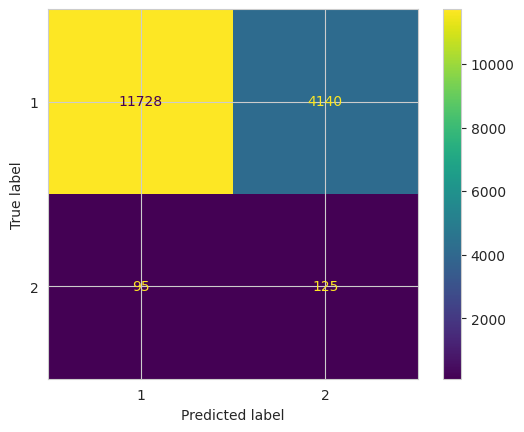

0.6536396865045718

In [202]:
auc_prs = evaluate_model(disease, model_prs, prs, meta, pheno, 'white_british', roc_auc_score, plot_cm=True)
auc_prs

Computing score for disease HC385


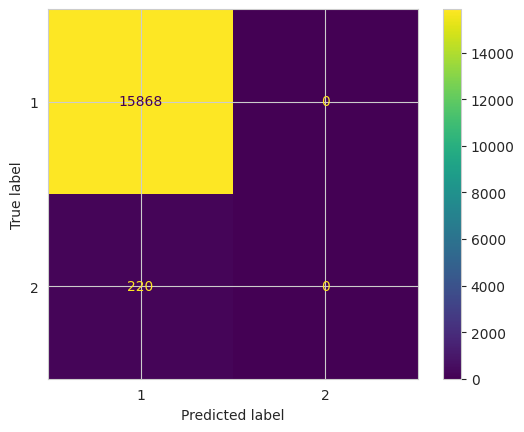

0.5

In [201]:
auc_no_prs = evaluate_model(disease, model_no_prs, prs, meta, pheno, 'white_british', roc_auc_score, plot_cm=True)
auc_no_prs

# Compute AUC

In [274]:
def mean_fill_and_scale(df):
    
    imp    = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler = StandardScaler()    
    columns = df.columns
    index   = df.index

    df = imp.fit_transform(df)
    df = scaler.fit_transform(df)
    df = pd.DataFrame(df, columns=columns, index=index)

    return df

In [275]:
def evaluate_model(disease, model, prs, meta, pheno, population, metric_function, plot_cm=False, verbose=False):
    """
    Evaluate the model for the specified disease using a given metric function.
    
    Parameters:
    - disease (str): Disease name.
    - model (model object): Trained model.
    - prs (DataFrame): DataFrame containing PRS data.
    - meta (DataFrame): Metadata.
    - pheno (DataFrame): Phenotype data.

    Returns:
    - metric (float): Metric score.
    """

    if verbose == True:
        print('Computing score for disease ' + disease)
        
    data = prs[['PRS_' + disease, 'final_split']].join(meta, how='inner')
    features = list(model.feature_names_in_)

    X      = data[data.population == population]
    X      = X.drop(['IID', 'population', 'age0', 'age1', 'age2', 'age3'], axis=1)
    
    X_test = X[X.final_split == 'test'].drop(['final_split', 'split'], axis=1)  
    X_test = X_test[features]
    X_test = mean_fill_and_scale(X_test)

    y      = pheno[pheno.population == population]
    y_test = y[y.final_split == 'test'][disease]
    
    if len(y_test.unique()) > 2:
        idxs_to_rm = y_test.index[y_test == -9].tolist()
        y_test = y_test.drop(index=idxs_to_rm)
        X_test = X_test.drop(index=idxs_to_rm)
        
    y_preds = model.predict(X_test)
    metric  = metric_function(y_test, y_preds)

    if plot_cm == True:
        cm = confusion_matrix(y_test, y_preds, labels = model.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
        disp.plot()
        plt.show()
    
    return metric

In [276]:
def compare_aucs(auc_list1, auc_list2, name1, name2):
    """
    Compares two lists of AUCs, computes how many times one beats the other, 
    and calculates the average difference in AUCs.

    Parameters:
    - auc_list1, auc_list2 (list): Lists of AUC values.
    - name1, name2 (str): Names for the two lists for display.

    Returns:
    - str: A nicely formatted string that provides a comparison summary.
    """
    
    if len(auc_list1) != len(auc_list2):
        raise ValueError("Both AUC lists should be of the same length.")
    
    wins1 = sum([1 for a, b in zip(auc_list1, auc_list2) if a > b])
    wins2 = sum([1 for a, b in zip(auc_list1, auc_list2) if b > a])
    ties = len(auc_list1) - wins1 - wins2
    avg_diff = sum([a - b for a, b in zip(auc_list1, auc_list2)]) / len(auc_list1)

    result_str = (f"{name1} beats {name2} {wins1} times. "
                  f"{name2} beats {name1} {wins2} times. "
                  f"There are {ties} ties. "
                  f"The average difference in AUC is {avg_diff:.4f} (positive value indicates {name1} is higher on average).")

    return result_str

# Plot AUCs

In [277]:
def plot_sorted_disease_auc(disease_names, aucs_sa, population):
    """
    Plot AUC scores for diseases, sorted by AUC values.
    
    Parameters:
    - disease_names (list): Names of diseases.
    - aucs_sa (list): AUC scores for WB Models on SA.
    """
    # Ensure data is sorted by values for better visualization
    sorted_indices = sorted(range(len(aucs_sa)), key=lambda k: aucs_sa[k], reverse=True)
    diseases_sorted = [disease_names[i] for i in sorted_indices]
    values = [aucs_sa[i] for i in sorted_indices]

    # Styling
    sns.set_style("whitegrid")
    palette = sns.cubehelix_palette(start=2.8, rot=0, dark=0.2, light=0.8, reverse=True)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=values, y=diseases_sorted, palette=palette, s=150, edgecolor='w', linewidth=0.5)  # s is the size of the points
    plt.xlabel('AUC scores', fontsize=14)
    plt.ylabel('Diseases', fontsize=14)
    plt.title('L1-penalized Logistic Regression of White British models on ' + population, fontsize=16)
    plt.xlim(0.4, 1.0)  # Adjust the x-axis limits if needed
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

In [278]:
def plot_disease_auc(disease_names, aucs_wb, aucs_sa, label_1, label_2):
    """
    Plot AUC scores for diseases using side-by-side subplots.
    
    Parameters:
    - disease_names (list): Names of diseases.
    - aucs_wb (list): AUC scores for WB Models on WB.
    - aucs_sa (list): AUC scores for WB Models on SA.
    """
    # Split diseases and scores into two lists for two subplots
    diseases1 = disease_names[:10]
    diseases2 = disease_names[10:]

    auc_wb_1 = aucs_wb[:10]
    auc_wb_2 = aucs_wb[10:]

    auc_sa_1 = aucs_sa[:10]
    auc_sa_2 = aucs_sa[10:]

    # Create two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    y_positions1 = np.arange(len(diseases1))
    y_positions2 = np.arange(len(diseases2))

    offset = 0.2

    # Plotting on the first subplot
    ax1.scatter(auc_wb_1, y_positions1 - offset, color='green', label=label_1)
    ax1.scatter(auc_sa_1, y_positions1 + offset, color='blue', label=label_2)
    ax1.set_yticks(y_positions1)
    ax1.set_yticklabels(diseases1)
    ax1.set_xlabel("AUC")
    ax1.set_title("Demographics")
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
    ax1.legend()

    # Plotting on the second subplot
    ax2.scatter(auc_wb_2, y_positions2 - offset, color='green', label=label_1)
    ax2.scatter(auc_sa_2, y_positions2 + offset, color='blue', label=label_2)
    ax2.set_yticks(y_positions2)
    ax2.set_yticklabels(diseases2)
    ax2.set_xlabel("AUC")
    ax2.set_title("Demographics")
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
    ax2.legend()

    # Ensure tight layout
    plt.tight_layout(pad=2)
    plt.show()

## AUC for White British models on WB

In [279]:
def get_metric_list(diseases, models, population, prs, meta, pheno, metric_function, verbose):

    metrics = []

    for i in range(len(diseases)):

        metric = evaluate_model(diseases[i], models[i], prs, meta, pheno, population, metric_function, verbose)
        metrics.append(metric)

    return metrics

In [282]:
aucs_wb_on_wb_with_prs    = get_metric_list(diseases, models_wb_with_prs, 'white_british', prs, meta, pheno, metrics.roc_auc_score, verbose=False)
aucs_wb_on_sa_with_prs    = get_metric_list(diseases, models_wb_with_prs, 's_asian', prs, meta, pheno, metrics.roc_auc_score, verbose=False)

In [283]:
aucs_wb_on_wb_without_prs = get_metric_list(diseases, models_wb_without_prs, 'white_british', prs, meta, pheno, metrics.roc_auc_score, verbose=False)
aucs_wb_on_sa_without_prs = get_metric_list(diseases, models_wb_without_prs, 's_asian', prs, meta, pheno, metrics.roc_auc_score, verbose=False)

In [301]:
aucs_wb_on_wb_only_prs = get_metric_list(diseases, models_wb_only_prs, 'white_british', prs, meta, pheno, metrics.roc_auc_score, verbose=False)
aucs_wb_on_sa_only_prs = get_metric_list(diseases, models_wb_only_prs, 's_asian', prs, meta, pheno, metrics.roc_auc_score, verbose=False)

## AUC plot of White British models on South Asians

/tmp/ipykernel_140790/2517924918.py:20: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=values, y=diseases_sorted, palette=palette, s=150, edgecolor='w', linewidth=0.5)  # s is the size of the points


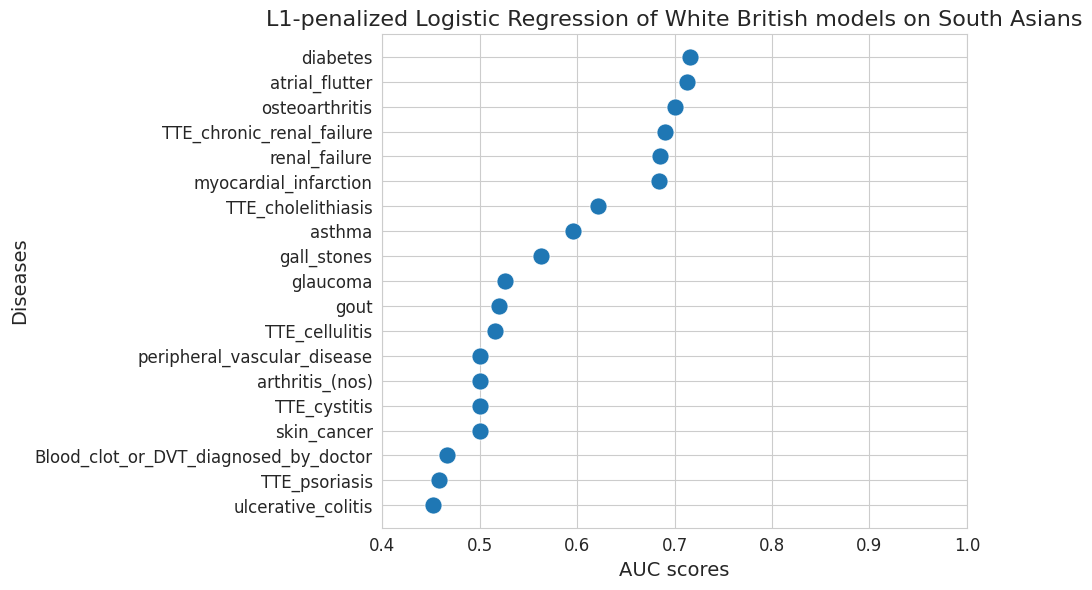

In [216]:
plot_sorted_disease_auc(disease_names, aucs_sa_on_sa_with_prs, 'South Asians')

## AUC White British models on White British

/tmp/ipykernel_140790/2517924918.py:20: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=values, y=diseases_sorted, palette=palette, s=150, edgecolor='w', linewidth=0.5)  # s is the size of the points


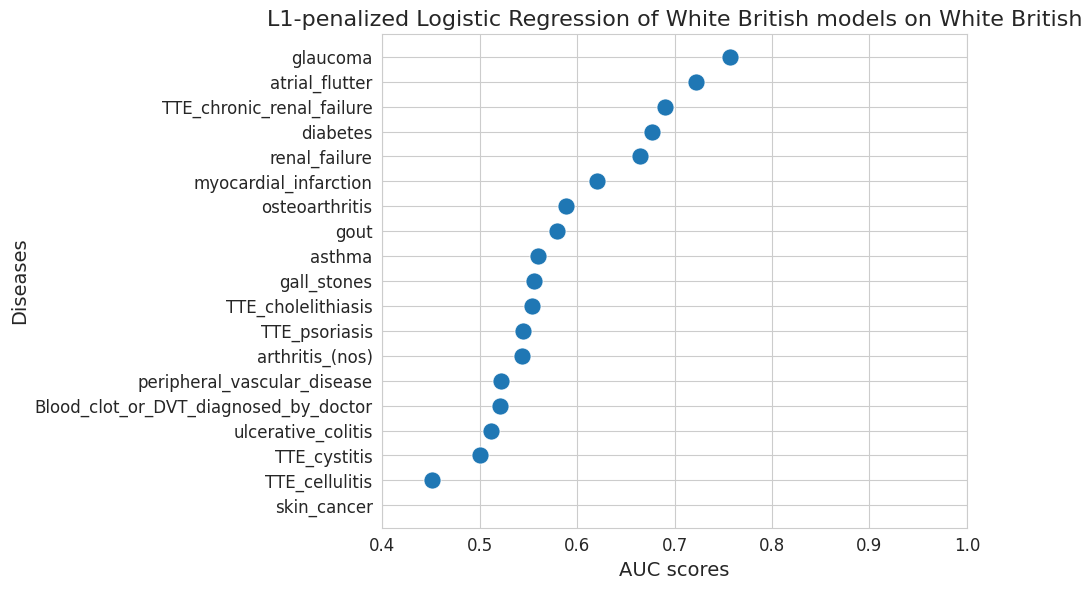

In [217]:
plot_sorted_disease_auc(disease_names, aucs_wb_on_sa_with_prs, 'White British')

## Comparison by ethnicity

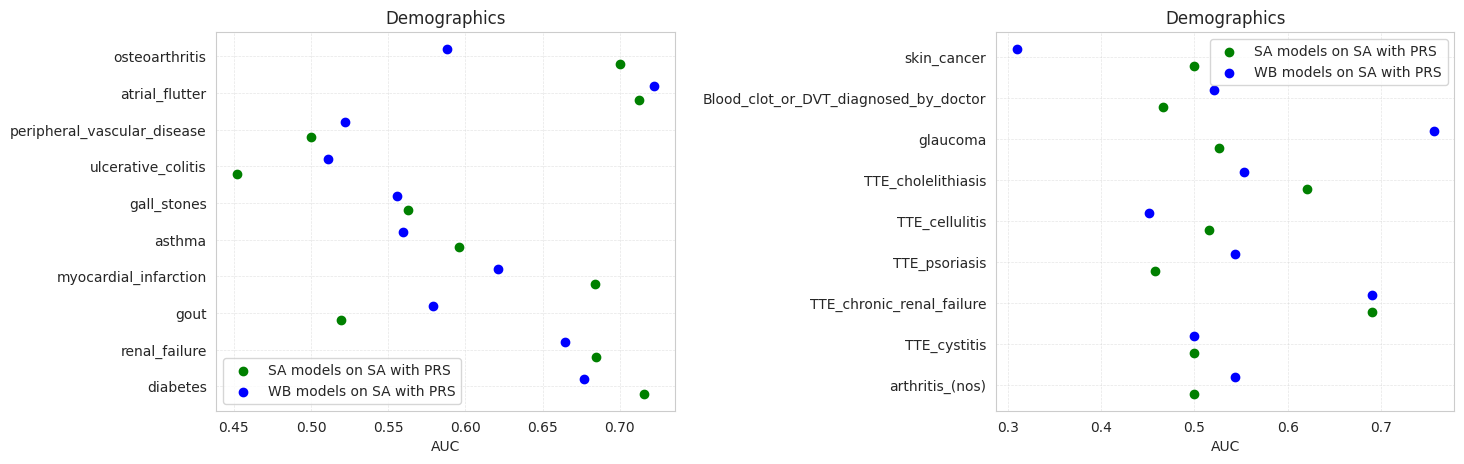

In [219]:
plot_disease_auc(disease_names, aucs_sa_on_sa_with_prs, aucs_wb_on_sa_with_prs, 'SA models on SA with PRS', 'WB models on SA with PRS')

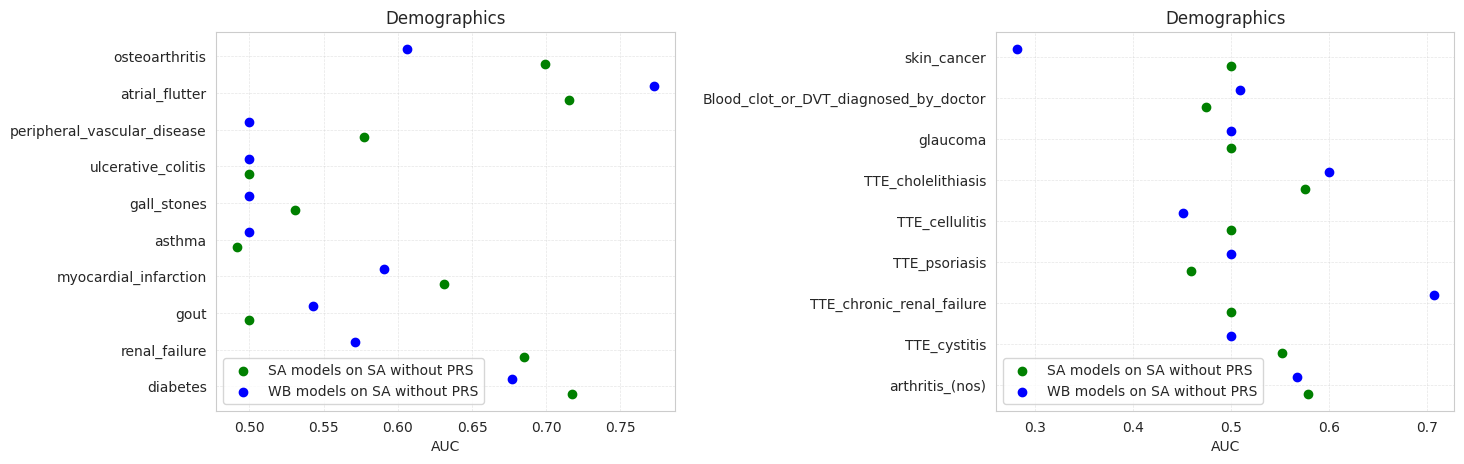

In [232]:
plot_disease_auc(disease_names, aucs_sa_on_sa_without_prs, aucs_wb_on_sa_without_prs, 'SA models on SA without PRS', 'WB models on SA without PRS')

# Side-by-side comparison

In [237]:
len(aucs_wb_on_sa_with_prs)

19

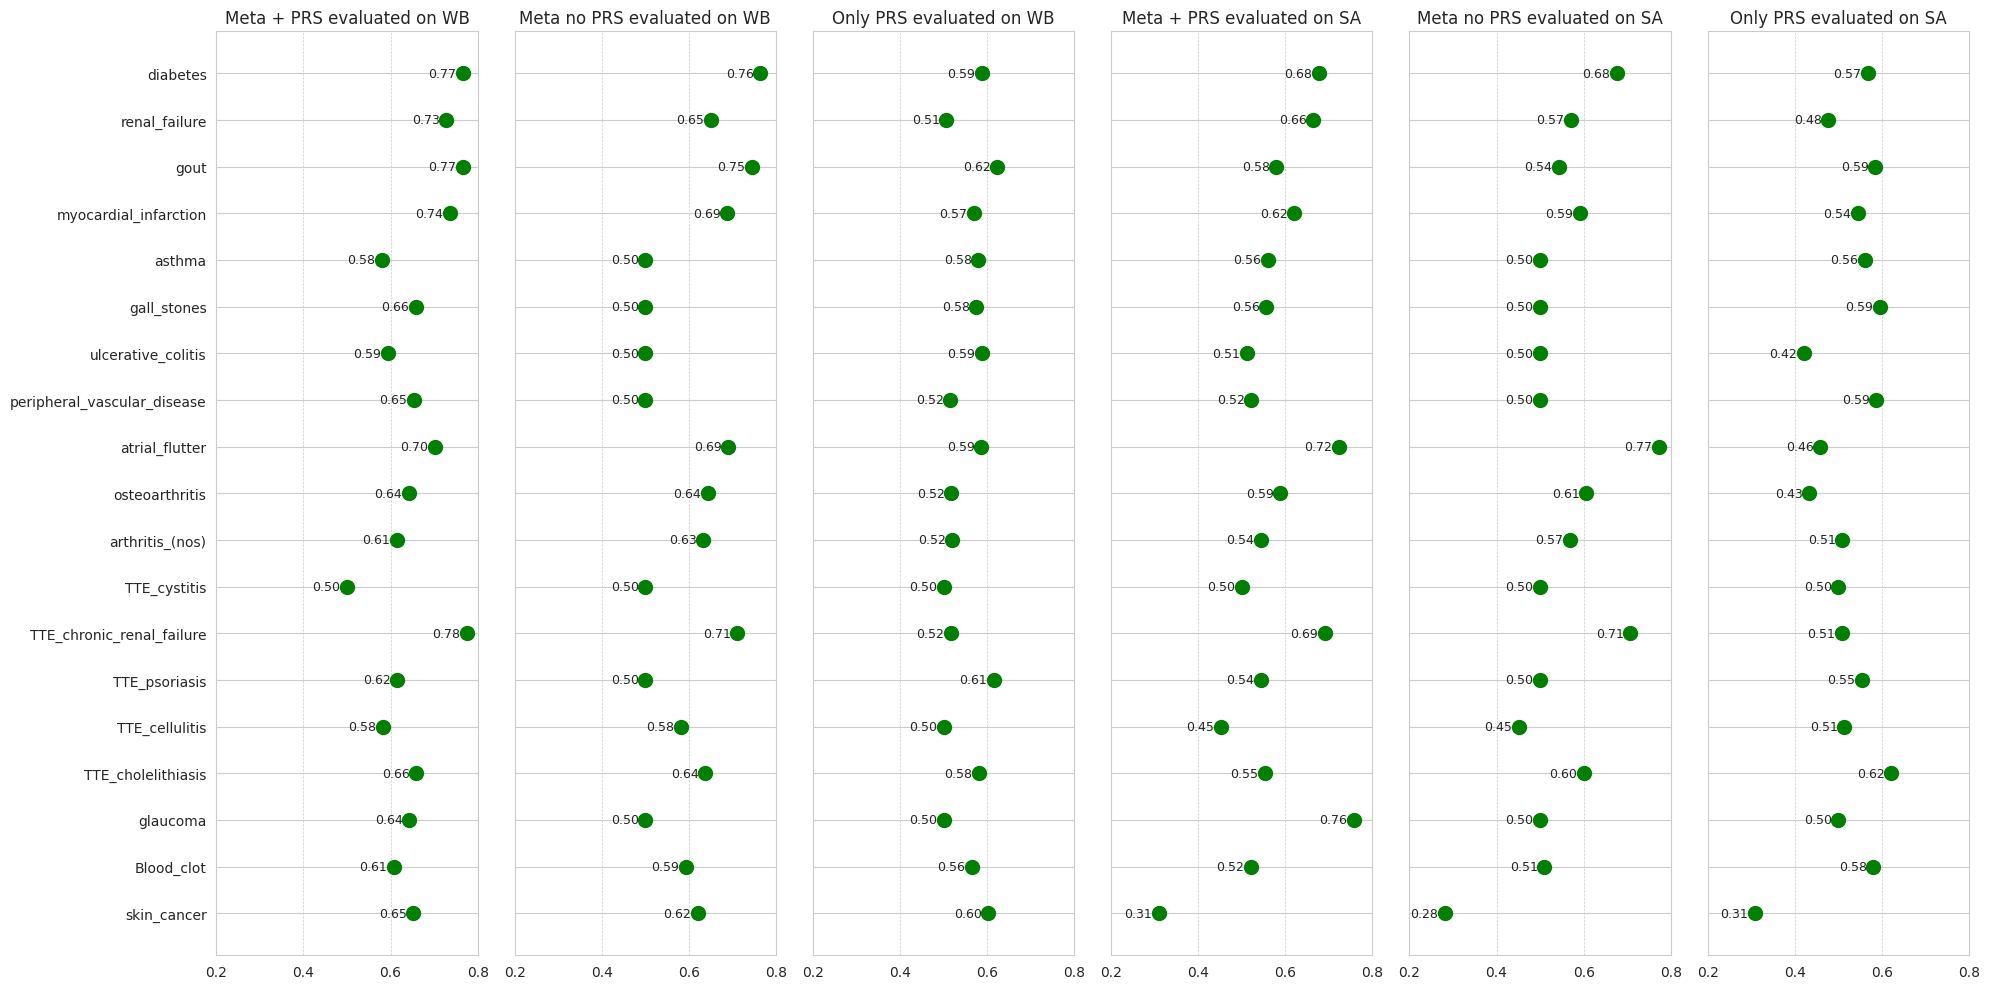

In [310]:
def plot_auc_scores(diseases, aucs_list, titles):
    plt.figure(figsize=(20, 10))
    
    for subplot_idx, auc_values in enumerate(aucs_list, 1):
        ax = plt.subplot(1, len(aucs_list), subplot_idx)
        
        # Scatter plot and text
        ax.scatter(auc_values, diseases, s=100, c='green', zorder=2)
        for i, (disease, auc) in enumerate(zip(diseases, auc_values)):
            ax.text(auc - 0.015, disease, f'{auc:.2f}', ha='right', va='center', fontsize=9, zorder=1)
        
        # Set y-ticks and invert y-axis
        ax.set_yticks(diseases)
        ax.invert_yaxis()
        
        # Set title and grid
        ax.set_title(titles[subplot_idx - 1])
        ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
        
        # Set x-axis limits
        ax.set_xlim(0.2, 0.8)
        
        # Remove y-ticks and y-labels for subplots other than the first
        if subplot_idx != 1:
            ax.set_yticklabels([])
    
    plt.tight_layout()
    plt.show()

# Define plot titles for each of the 4 plots
titles = [
    "Meta + PRS evaluated on WB",
    "Meta no PRS evaluated on WB",
    "Only PRS evaluated on WB",
    "Meta + PRS evaluated on SA",
    "Meta no PRS evaluated on SA",
    "Only PRS evaluated on SA"
]

plot_auc_scores(disease_names, 
                [aucs_wb_on_wb_with_prs, aucs_wb_on_wb_without_prs, aucs_wb_on_wb_only_prs, 
                 aucs_wb_on_sa_with_prs, aucs_wb_on_sa_without_prs, aucs_wb_on_sa_only_prs], titles)



In [287]:
print(compare_aucs(aucs_wb_on_sa_with_prs, aucs_wb_on_sa_without_prs, 'WB with PRS on SA', 'WB without PRS on SA'))

WB with PRS on SA beats WB without PRS on SA 12 times. WB without PRS on SA beats WB with PRS on SA 5 times. There are 2 ties. The average difference in AUC is 0.0258 (positive value indicates WB with PRS on SA is higher on average).


## Mean AUCs

In [295]:
mean(aucs_wb_on_wb_with_prs)

0.6562775774455272

In [294]:
mean(aucs_wb_on_wb_without_prs)

0.6029925122959751

In [296]:
mean(aucs_wb_on_sa_with_prs)

0.5719778327583702

In [297]:
mean(aucs_wb_on_sa_without_prs)

0.5461864686108687